In [24]:
import time
import os
import h5py
import math
from pprint import pprint

import scipy.io 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa

print("TensorFlow version:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, LeakyReLU
from tensorflow.keras import Model, utils

TensorFlow version: 2.10.1
Name: /physical_device:GPU:0   Type: GPU


In [25]:
rawdata = scipy.io.loadmat("data/TrainData")
print(type(rawdata))
print(list(rawdata.keys()))
particle = np.array(rawdata['TrainData'])
print(particle.shape)
pprint(particle[:,0])

<class 'dict'>
['__header__', '__version__', '__globals__', 'TrainData']
(9, 2000)
array([1.66000000e+02, 1.41000000e+02, 3.50000000e+01, 5.59348234e-01,
       1.22520000e+04, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00])


# TrainData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. training type
8. training binary type
9. training binary type

# TestData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. note

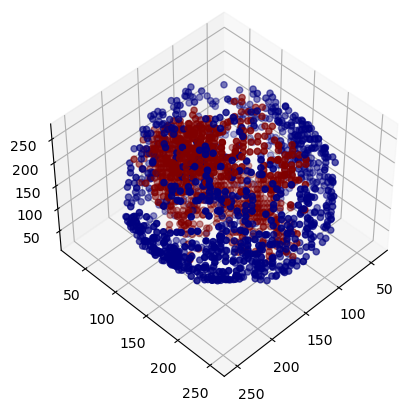

In [26]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax = plt.axes(projection='3d')

x = particle[0,:]
y = particle[1,:]
z = particle[2,:]
c = particle[6,:]
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(45, 45)

In [27]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=c,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [28]:
##-----------------------------------------------------------------------------
## Load Training data
##-----------------------------------------------------------------------------
# We use h5py as an alternate to scipy.io, because matlab v7.3 files use HDF format.
# Remember h5py.File acts like a Python dictionary.
AtomIntensity = h5py.File('data/dAtomIntensity_TrainData_New.mat', 'r')
print(type(AtomIntensity))
print(list(AtomIntensity.keys()))
Intensity = np.array(AtomIntensity.get('dAtomIntensity_TrainData_New'))
print(Intensity.shape)

<class 'h5py._hl.files.File'>
['dAtomIntensity_TrainData_New']
(2000, 7, 7, 7)


In [29]:
AtomType = scipy.io.loadmat('data/iAtomType_New')
print(type(AtomType))
print(list(AtomType.keys()))
Types = np.array(AtomType['iAtomType_New'])
print(Types.shape)
print(Types[0,:])

<class 'dict'>
['__header__', '__version__', '__globals__', 'iAtomType_New']
(2000, 1)
[1]


In [30]:
##-----------------------------------------------------------------------------
## Training set & Testing set
##-----------------------------------------------------------------------------
# rearrange the order of Intensity & Type
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html
r = np.random.permutation(len(Intensity))
print(r)
x_train = Intensity[r]
x_label = Types[r] -1    # 改成0和1
print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label.shape))

for i in range(3):
    print("Before permutation")
    print(r[i], Intensity[r[i],:,1,1])
    print("After permutation")
    print(i, x_train[i,:,1,1])

[1367  541 1411 ...  922  900 1998]
x_train.shape=(2000, 7, 7, 7), x_label.shape=(2000, 1)
Before permutation
1367 [0.48337801 0.39023581 0.36722112 0.63086637 0.58629808 0.28334062
 0.03981046]
After permutation
0 [0.48337801 0.39023581 0.36722112 0.63086637 0.58629808 0.28334062
 0.03981046]
Before permutation
541 [0.0052932  0.         0.01737875 0.16229216 0.18562579 0.0494712
 0.01359008]
After permutation
1 [0.0052932  0.         0.01737875 0.16229216 0.18562579 0.0494712
 0.01359008]
Before permutation
1411 [0.372345   0.53897813 0.66652339 0.7096367  0.70521166 0.48696889
 0.5117283 ]
After permutation
2 [0.372345   0.53897813 0.66652339 0.7096367  0.70521166 0.48696889
 0.5117283 ]


In [31]:
# Extend one more dim for channel
x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
#x_train = x_train.reshape(x_train.shape[0], 7, 7, 7, 1)

# Change label from single value to one-hot vector.
x_label_R = utils.to_categorical(x_label, num_classes=2)

print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label_R.shape))

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, x_label_R)).batch(32)


x_train.shape=(2000, 7, 7, 7, 1), x_label.shape=(2000, 2)


In [32]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv3D(filters=32, kernel_size=(3,3,3), padding='same', activation='linear')
        self.leakrelu1 = LeakyReLU(alpha=0.1)
        self.maxpool1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)
        self.conv2 = Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation='relu')
        self.leakrelu2 = LeakyReLU(alpha=0.1)
        self.maxpool2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)
        self.flatten = Flatten()
        self.d1 = Dense(2048, activation='linear')
        self.leakrelu3 = LeakyReLU(alpha=0.1)
        self.dropout1 = Dropout(0.5)
        self.d2 = Dense(256, activation='linear')
        self.leakrelu4 = LeakyReLU(alpha=0.1)
        self.dropout2 = Dropout(0.5)
        self.d3 = Dense(64, activation='linear')
        self.leakrelu5 = LeakyReLU(alpha=0.1)
        self.dropout3 = Dropout(0.5)
        self.d4 = Dense(2, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.leakrelu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.leakrelu2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.leakrelu3(x)
        x = self.dropout1(x)
        x = self.d2(x)
        x = self.leakrelu4(x)
        x = self.dropout2(x)
        x = self.d3(x)
        x = self.leakrelu5(x)
        x = self.dropout3(x)
        return self.d4(x)

# Create an instance of the model
model = MyModel()

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
# Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# verbose=2 is recommended when not running interactively
train_history=model.fit(x = x_train, y = x_label_R, validation_split=0.1, epochs=20, batch_size=100, verbose=2)

model.save('my_CNNmodel')  

Epoch 1/20
18/18 - 3s - loss: 0.4101 - accuracy: 0.7656 - val_loss: 0.0481 - val_accuracy: 1.0000 - 3s/epoch - 159ms/step
Epoch 2/20
18/18 - 0s - loss: 0.0138 - accuracy: 0.9989 - val_loss: 3.9867e-05 - val_accuracy: 1.0000 - 225ms/epoch - 13ms/step
Epoch 3/20
18/18 - 0s - loss: 0.0083 - accuracy: 0.9983 - val_loss: 3.4033e-07 - val_accuracy: 1.0000 - 200ms/epoch - 11ms/step
Epoch 4/20
18/18 - 0s - loss: 0.0631 - accuracy: 0.9889 - val_loss: 3.1829e-07 - val_accuracy: 1.0000 - 199ms/epoch - 11ms/step
Epoch 5/20
18/18 - 0s - loss: 0.0166 - accuracy: 0.9956 - val_loss: 1.8029e-05 - val_accuracy: 1.0000 - 200ms/epoch - 11ms/step
Epoch 6/20
18/18 - 0s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.0052e-04 - val_accuracy: 1.0000 - 212ms/epoch - 12ms/step
Epoch 7/20
18/18 - 0s - loss: 1.4663e-04 - accuracy: 1.0000 - val_loss: 4.0090e-06 - val_accuracy: 1.0000 - 228ms/epoch - 13ms/step
Epoch 8/20
18/18 - 0s - loss: 1.5346e-04 - accuracy: 1.0000 - val_loss: 3.4028e-06 - val_accuracy: 1.0000 

INFO:tensorflow:Assets written to: my_CNNmodel\assets


INFO:tensorflow:Assets written to: my_CNNmodel\assets


In [34]:
print(model.summary())

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           multiple                  896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   multiple                  0         
                                                                 
 max_pooling3d_2 (MaxPooling  multiple                 0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           multiple                  55360     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   multiple                  0         
                                                                 
 max_pooling3d_3 (MaxPooling  multiple                 0         
 3D)                                                    

In [38]:
# https://keras.io/zh/visualization/
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='accuracy') else 'upper right'

    plt.legend(['train', 'validation'], loc=legendLoc)

    plt.show()

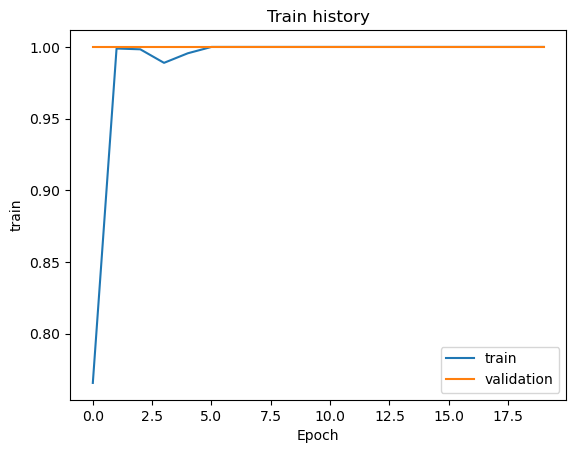

In [39]:
show_train_history(train_history, 'accuracy', 'val_accuracy')

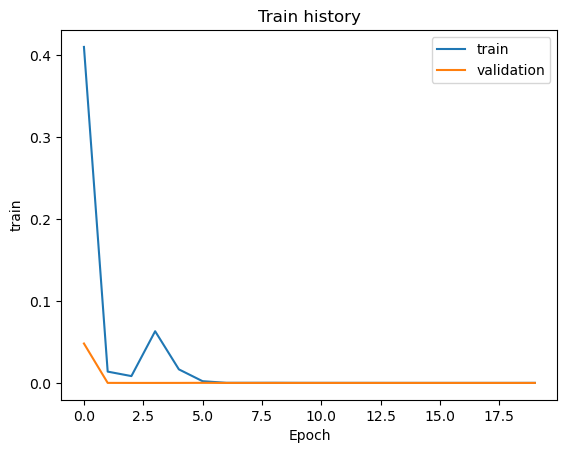

In [40]:
show_train_history(train_history, 'loss', 'val_loss')